In [1]:
from ledoh_torch import minimum_acos_distance_row
import wandb
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import numpy as np

from plot_utils import match_run, get_regularizer_runs, get_zoomed_subplot, add_data_to_ax

In [2]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=15)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

In [3]:
entity = "hcbakker_runs"
api = wandb.Api()
# runs = api.runs(f"{entity}/{project_name}")


n = 20000
d = 128
epochs = 5000

In [4]:
colors = {
    25: "cyan",
    50: "skyblue",
    100: "yellow",
    250: "green",
    500: "pink",
    1000: "red",
    2000: "purple",
    3000: "brown",
    4000: "orange",
    5000: "blue",
    6400: "green"
}

def adjust_batch_size(batch_size, n):
    return np.sqrt(batch_size * n)

adjusted_colors = {int(np.round(adjust_batch_size(batch_size, n))): color for batch_size, color in colors.items()}

In [5]:
titles = {
    "mmd": "MMD", "sliced-ax": "Sliced", "mma": "MMA", "mmd-semi": "MMD semi", "lloyd": "Lloyd"
}

In [6]:
def get_minds(run, regularizer):
    path_min_d = run.logged_artifacts()[3].download()
    table_path = f"{path_min_d}/{regularizer}/dmin_hist.table.json"
    
    with open(table_path) as file:
        json_dict = json.load(file)
    
    assert json_dict["columns"] == ["dmin"]
    minds = np.array(json_dict["data"]).flatten()
    return minds

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


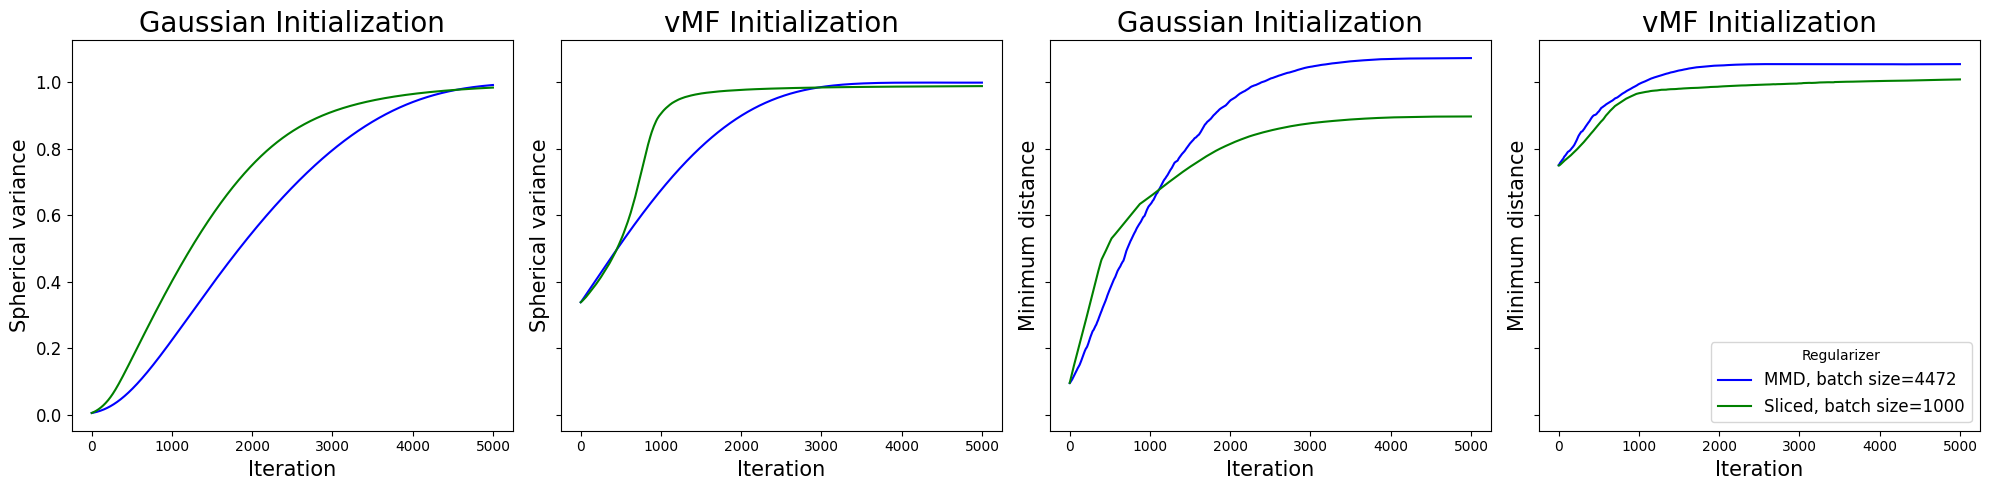

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5), sharey=True)

all_r_colors = {
    # "lloyd": "red",
    "mmd": "blue",
    "sliced-ax": "green",
    # "mmd-semi": "orange",
    # "mma": "purple"
}

minds_all = dict()

for j, regularizer in enumerate(all_r_colors.keys()):
    # if runs are spread across projects
    for project_name in ["toy_regularizer_collective"]:
        for batch_size in [1000]:
            runs = api.runs(f"{entity}/{project_name}")
            
            adjusted_batch_size = int(np.round(adjust_batch_size(batch_size, n)))
            n_samples = batch_size
            
            for i, init_method in enumerate(["gaussian", "vmf150"]):
                run_conditions = dict(n=n, d=d, regularizer=regularizer, init=init_method, epochs=epochs)
                
                if regularizer == "mmd":
                    param_conditions = dict(batch_size=[adjusted_batch_size])
                    unit_val = adjusted_batch_size
                elif regularizer == "lloyd":
                    param_conditions = dict(n_samples=[n_samples])
                    unit_val = n_samples
                elif regularizer == "sliced-ax":
                    param_conditions = dict(batch_size=[batch_size])
                    unit_val = batch_size
                elif regularizer == "mma":
                    param_conditions = dict(batch_size=[adjusted_batch_size])
                    unit_val = adjusted_batch_size
                elif regularizer == "mmd-semi":
                    param_conditions = dict(batch_size=[batch_size])
                    unit_val = batch_size
                else:
                    raise ValueError()
        
                selected_run = [run for run in runs if match_run(run=run, conditions=run_conditions, params=param_conditions)]
    
                if len(selected_run) == 0:
                    continue

                # NOTE: we assume that each param combination is unique,
                # i.e,. it assumes there are no runs with identical set up
                selected_run = selected_run[0]

                minds_all[(regularizer, init_method)] = get_minds(selected_run, regularizer)
                linestyle = "solid" if batch_size != 6400 else "dotted"
                unit = "samples" if regularizer == "lloyd" else "batch size"
                label = f"{titles[regularizer]}, {unit}={unit_val}"
                axes[i].plot(selected_run.summary["cvars"], label=label, color=all_r_colors[regularizer], linestyle=linestyle)
                axes[i].set_ylabel("Spherical variance")
                axes[i + 2].plot(selected_run.summary["minds"], label=label, color=all_r_colors[regularizer], linestyle=linestyle)
                axes[i + 2].set_ylabel("Minimum distance")
        

axes[0].set_title("Gaussian Initialization")
axes[2].set_title("Gaussian Initialization")

axes[1].set_title("vMF Initialization")
axes[3].set_title("vMF Initialization")

for i in range(4):
    axes[i].set_xlabel("Iteration")


# Shrink current axis by 20%
box = axes[3].get_position()
axes[3].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
axes[3].legend(title="Regularizer", loc='lower right')

plt.tight_layout()
plt.savefig("toy_results.pdf", bbox_inches="tight")
plt.show()



In [8]:
mmd_minds = minds_all[("mmd", "gaussian")]
print("mmd min dist", min(mmd_minds))

sliced_minds = minds_all[("sliced-ax", "gaussian")]
print("sliced min dist", min(sliced_minds))

mmd min dist 1.073198676109314
sliced min dist 0.8974756002426147


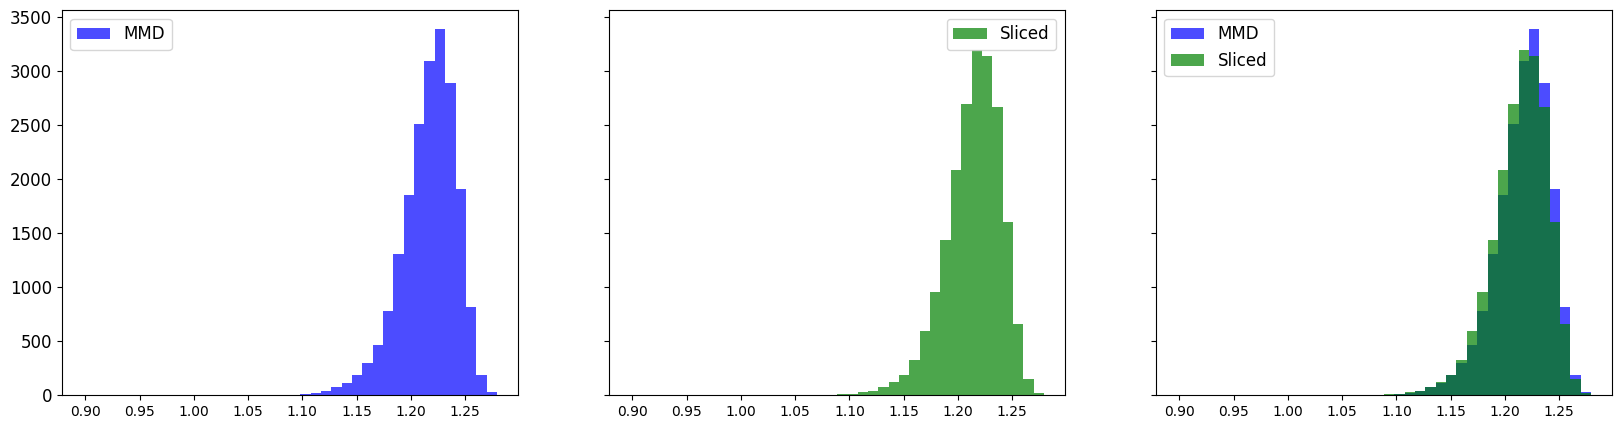

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharey=True)
bins=np.histogram(np.hstack(tuple(minds_all.values())), bins=40)[1]

axes[0].hist(mmd_minds, bins=bins, label="MMD", color="blue", alpha=0.7)
axes[0].legend()
axes[1].hist(sliced_minds, bins=bins, label="Sliced", color="green", alpha=0.7)
axes[1].legend()
axes[2].hist(mmd_minds, bins=bins, label="MMD", color="blue", alpha=0.7)
axes[2].hist(sliced_minds, bins=bins, label="Sliced", color="green", alpha=0.7)
axes[2].legend()

plt.show()